# Predictive Modelling- Imbalance Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
random_state = 42

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import  f1_score, r2_score, recall_score,  precision_score,classification_report,accuracy_score, auc, roc_curve,roc_auc_score
from imblearn.combine import SMOTEENN
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_curve, plot_confusion_matrix,plot_precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
import time
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
churn_data= pd.read_csv("/content/drive/MyDrive/project/Project_ChurnPrediction/Notebooks and Data/Data/clean_churn.csv")
churn_data.sample(5, random_state= 42)

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_cluster_High,tenure_cluster_Low,tenure_cluster_Mid,monthlycharges_cluster_High,monthlycharges_cluster_Low,monthlycharges_cluster_Mid,totalcharges_cluster_high,totalcharges_cluster_low,totalcharges_cluster_medium
2476,2476,0,0,1,1,3,1,1,69,235.00,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
6773,6773,0,0,1,1,72,1,1,79,5661.70,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0
6116,6116,1,0,1,0,71,1,0,80,5727.15,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0
3047,3047,1,0,1,1,25,1,1,75,1901.05,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
4092,4092,1,0,0,1,22,1,1,89,1949.40,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0


In [5]:
X = churn_data.drop(['Churn', 'Unnamed: 0'], axis= 1)
y = churn_data['Churn']

**Separate the data in independent and dependent variables**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2,random_state =42)
print(X_train.shape, y_test.shape)

(5625, 49) (1407,)


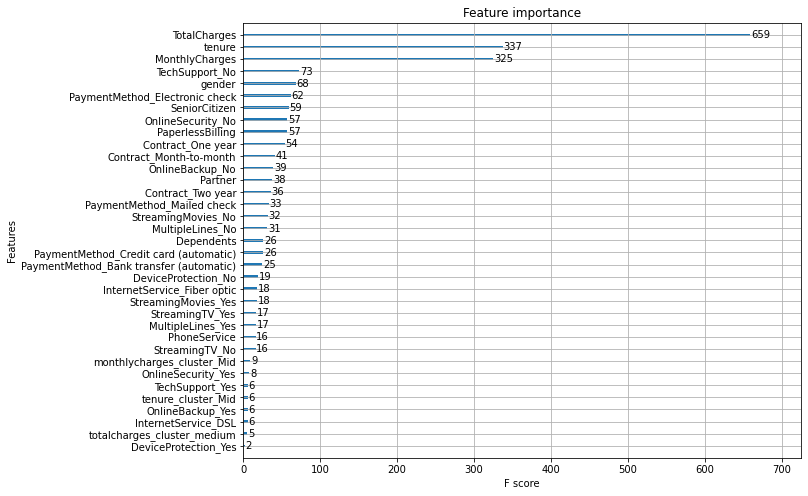

In [7]:
from xgboost import plot_importance
# use feature importance for feature selection, with fix for xgboost 1.0.2
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
	@property
	def coef_(self):
		return None
xgb_model = MyXGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)
plt.show()

**Drop variables those are having less less f-score**

In [9]:
X = churn_data.drop(['Unnamed: 0','DeviceProtection_Yes', 'totalcharges_cluster_medium', 'InternetService_DSL','OnlineBackup_Yes', 'monthlycharges_cluster_Mid', 'StreamingTV_No', 'Churn'], axis = 1)
y = churn_data['Churn']

**Split the data in to training and testing part**

**Default Classifiers**

**Metric:** False positive rate for highly imbalanced datasets is pulled down due to a large number of true negatives.

# Handling class imbalance using SMOTE based techniques

**Oversampling methods duplicate or create new synthetic examples in the minority class ( churn in the dataset)**

## SMOTE TECHNIQUE

In [10]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 4122, 1: 1503})
After Counter({0: 4122, 1: 4122})


## ADASYN



In [11]:
from imblearn.over_sampling import ADASYN

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 4122, 1: 1503})
After Counter({1: 4182, 0: 4122})


# Hybrid Technquies

**1) SMOTE+ Tomek Links**

In [12]:
from imblearn.combine import SMOTETomek

print('Original dataset shape {}'.format(Counter(y_train)))
# oversampling train dataset using SMOTE + tomek
smtom = SMOTETomek(random_state= 42)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)
counter = Counter(y_train_smtom)
print('Original dataset shape {}'.format(Counter(y_train_smtom)))

Original dataset shape Counter({0: 4122, 1: 1503})
Original dataset shape Counter({0: 3793, 1: 3793})


**SMOTE + Edited NearestNeighbors**

In [13]:
from imblearn.combine import SMOTEENN

print("orignal datset shape counter{}".format(Counter(y_train)))

# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

orignal datset shape counterCounter({0: 4122, 1: 1503})
After Counter({1: 2477, 0: 2102})



### Model Building - Imbalanced data

In [14]:
classifier = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

**Function for various metices**

In [15]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    #average_precision = average_precision_score(y_test, y_pred)
    
    fig, (ax1,ax2, ax3 ) = plt.subplots(3, 1, constrained_layout=True, figsize=(12, 10), dpi=60)
    
    plot_confusion_matrix(clf_model, X_test, y_test,  values_format= '.1f', ax=ax1,cmap= 'Wistia_r') # Confusion Matrix
    ax1.set_title("Confusion Matrix", fontdict = {'color':'Darkblue', 'size':12}) 
    for tick in ax1.xaxis.get_major_ticks():

      tick.label.set_fontsize(12) 
    for tick in ax1.yaxis.get_major_ticks():

      tick.label.set_fontsize(12)
    plt.figure(figsize = (12, 6))
    clf_report = classification_report( y_test,y_pred,output_dict= True,) # Classification Report
    report_df= pd.DataFrame(clf_report)
    sns.heatmap(report_df,annot= True, fmt= '.2f', ax=ax2, cmap= 'YlOrRd',linecolor= 'Darkblue',linewidths= .3, cbar = False)
    ax2.tick_params('y',labelrotation=45) 
    for tick in ax2.xaxis.get_major_ticks():

      tick.label.set_fontsize(12) 
    for tick in ax2.yaxis.get_major_ticks():
      tick.label.set_fontsize(9)
    ax2.set_title("Classification Report", weight = 'bold',fontdict = {'color':'Darkblue', 'fontsize':20})
    

    plt.figure(figsize=(12, 5)) 
    plot_precision_recall_curve(clf_model, X_test, y_test, ax = ax3, name = 'clf_model') # PR-Curve
    ax3.set_title("PR-Curve",fontdict = {'color':'Darkblue', 'size':12})
    for tick in ax3.xaxis.get_major_ticks():

      tick.label.set_fontsize(10) 
    for tick in ax3.yaxis.get_major_ticks():
      tick.label.set_fontsize(10) 

        
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
      
    classifier.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)
    fig.tight_layout()
    #AP_Score.append(average_precision_score(y_test, y_pred))

**Model(1):- Logistic Regression**




**1. Orignal Unsampled Data**

In [16]:
# Hyparameter tunning and cross validation
log_model = LogisticRegression()
log_params ={'C':np.logspace(-10, 1, 15), 'solver':['liblinear', 'newton-cg'],'class_weight':[None,'balanced'],'penalty':['l1','l2']}
cv = KFold(n_splits= 5, random_state= 42, shuffle= True)
# GridSearch
clf_lr = GridSearchCV(log_model, log_params, cv =cv , scoring = 'roc_auc', n_jobs= - 1).fit(X_train, y_train).fit(X_train, y_train)
pd.DataFrame.from_dict(clf_lr.best_params_, orient='index', columns = ['LogisticRegression'])

,LogisticRegression
C,0.0439397
class_weight,balanced
penalty,l2
solver,liblinear


AUC-ROC
0.8255670514375102


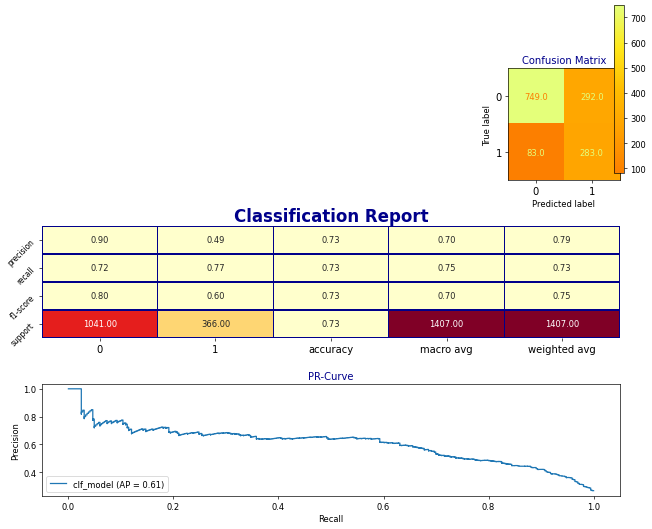

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [17]:
test_eval(clf_lr, X_test, y_test, 'Logistic Regression', 'actual')

**2.SMOTE Resampling**

In [18]:
clf_lr_smote = clf_lr.fit(X_train_sm, y_train_sm)
pd.DataFrame.from_dict(clf_lr_smote.best_params_, orient='index', columns = ['LogisticRegression (smote)'])

,LogisticRegression (smote)
C,0.0439397
class_weight,None
penalty,l2
solver,liblinear


AUC-ROC
0.8259108780439153


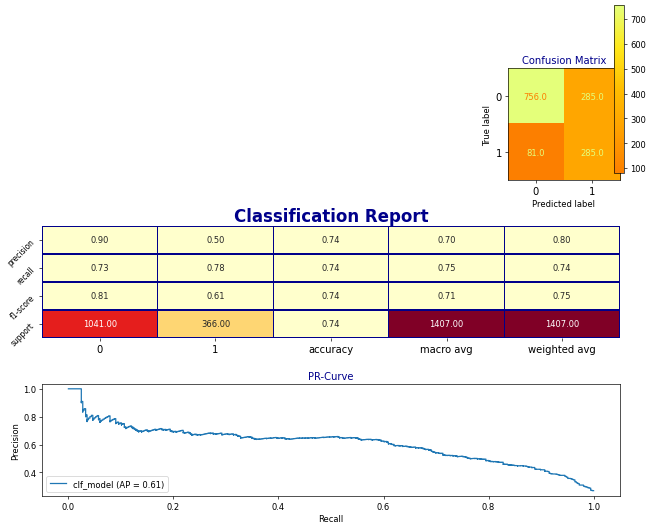

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [19]:
test_eval(clf_lr_smote, X_test, y_test, 'Logistic Regression', 'smote')

**3. ADASYN Resampling** 

In [20]:
clf_lr_ada = clf_lr.fit(X_train_ada, y_train_ada)
pd.DataFrame.from_dict(clf_lr_ada.best_params_, orient= 'index', columns = ['ADASYN-LogisticRegression'])

,ADASYN-LogisticRegression
C,0.0439397
class_weight,balanced
penalty,l2
solver,liblinear


AUC-ROC
0.8249712602951134


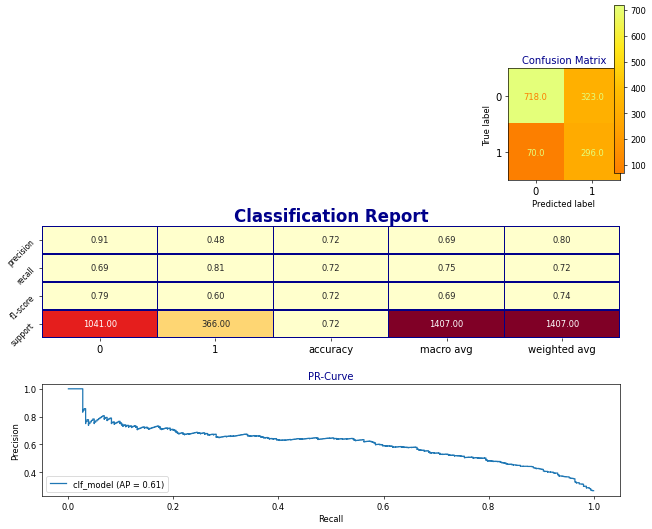

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [21]:
test_eval(clf_lr_ada, X_test, y_test, 'Logistic Regression', 'adasyn')

**4. SMOTE- Tmoke**

In [22]:
clf_lr_tmo = clf_lr.fit(X_train_smtom,y_train_smtom)

pd.DataFrame.from_dict(clf_lr_tmo.best_params_, orient= 'index', columns= ['Smote-tmoke (LogisticRegression'])

,Smote-tmoke (LogisticRegression
C,0.26827
class_weight,balanced
penalty,l1
solver,liblinear


AUC-ROC
0.8262271460291962


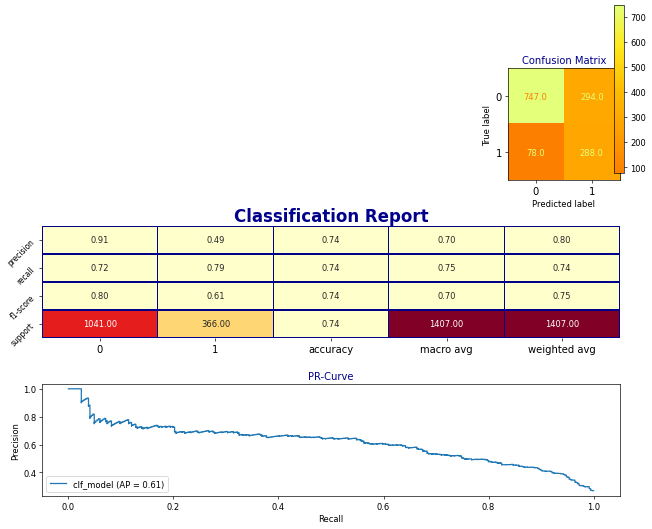

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [23]:
test_eval(clf_lr_tmo, X_test, y_test, 'Logistic Regression', 'smote+tomek')

5. **ENN**

In [24]:
clf_lr_enn = clf_lr.fit(X_train_smenn, y_train_smenn)
pd.DataFrame.from_dict(clf_lr_enn.best_params_, orient= 'index', columns= ['LogisticRegression-Smote-(ENN'])

,LogisticRegression-Smote-(ENN
C,0.26827
class_weight,balanced
penalty,l1
solver,liblinear


AUC-ROC
0.8170868700230443


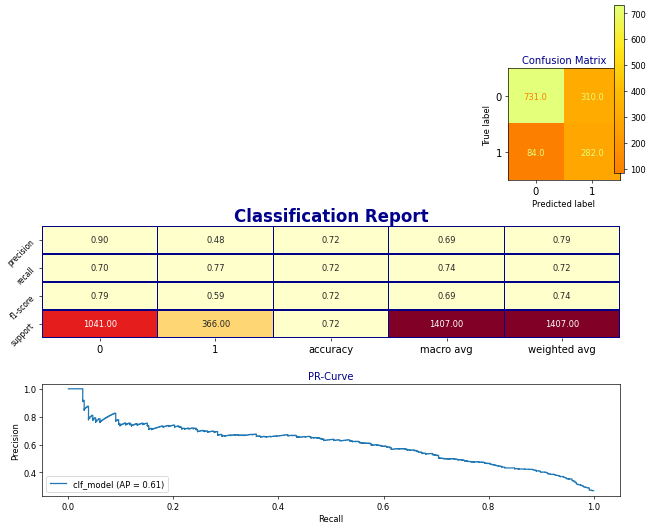

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [25]:
test_eval(clf_lr_enn, X_test, y_test, 'Logistic Regression', 'smote+enn')

# Model-2 Decision Tree

In [26]:
estimators = [2,10,30,50]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

1.  **Orignal Unsampled Data**

In [27]:
tree_param_grid = {'max_depth':max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf}
clf_df= GridSearchCV(DecisionTreeClassifier(), param_grid= tree_param_grid, cv = cv).fit(X_train, y_train)
pd.DataFrame.from_dict(clf_df.best_params_, orient= 'index', columns = ['DecisionTree (unsampled)'])

,DecisionTree (unsampled)
max_depth,5
min_samples_leaf,2
min_samples_split,2


AUC-ROC
0.8128638394146024


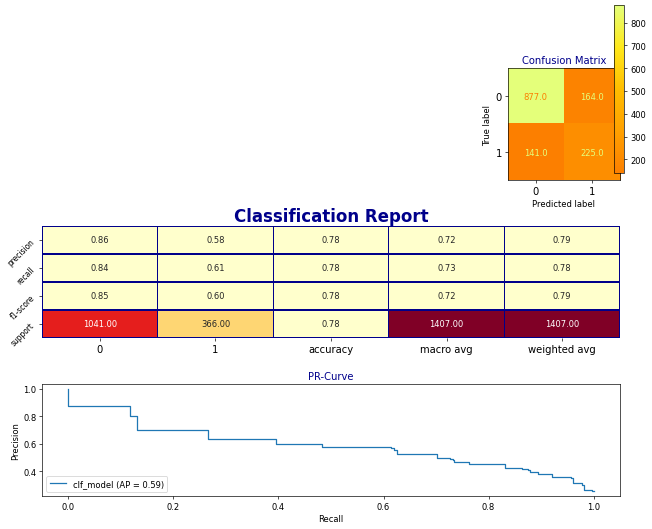

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [28]:
test_eval(clf_df, X_test, y_test, 'Decision Tree', 'actual')

2. **SMOTE Resampling**

In [29]:
clf_df_smote = clf_df.fit(X_train_sm, y_train_sm)
pd.DataFrame.from_dict(clf_df_smote.best_params_, orient= 'index', columns = ['DecisionTree (SMOTE)'])

,DecisionTree (SMOTE)
max_depth,9
min_samples_leaf,1
min_samples_split,15


AUC-ROC
0.7868681858028483


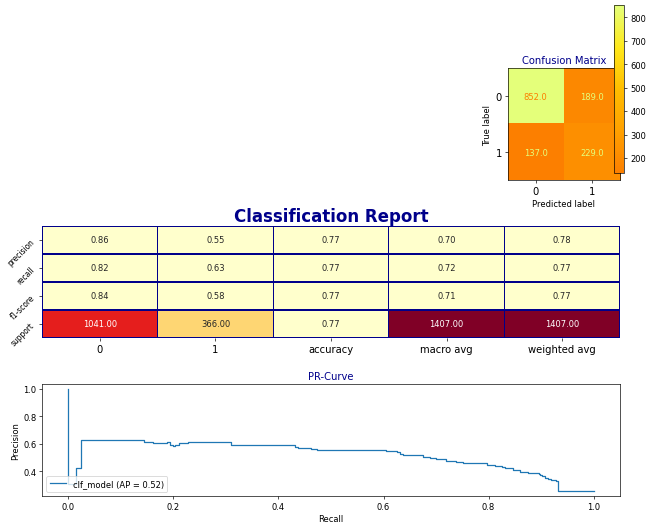

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [30]:
test_eval(clf_df_smote, X_test, y_test, 'Decision Tree', 'smote')

**3.ADASYN Resampling**

In [31]:
clf_df_ada = clf_df.fit(X_train_ada, y_train_ada)
df_params = clf_df_ada.best_params_
pd.DataFrame.from_dict(clf_df_ada.best_params_, orient= 'index', columns = ['DecisionTree (ADASYN)'])

,DecisionTree (ADASYN)
max_depth,9
min_samples_leaf,2
min_samples_split,15


AUC-ROC
0.7741636614646488


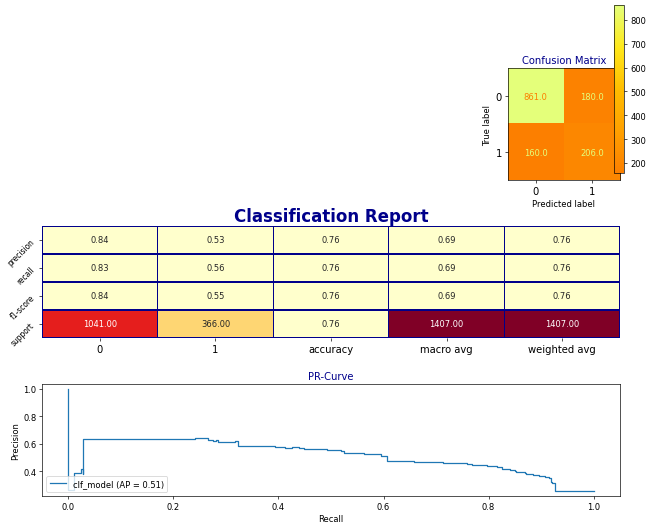

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [32]:
test_eval(clf_df_ada, X_test, y_test, 'Decision Tree', 'adasyn')

**4. SMOTE + Tomek Resampling**

In [33]:
clf_df_tom = clf_df.fit(X_train_smtom, y_train_smtom)
df_params = clf_df_tom.best_params_
pd.DataFrame.from_dict(clf_df_tom.best_params_, orient= 'index', columns = ['DecisionTree (SMOTE+Tomek)'])

,DecisionTree (SMOTE+Tomek)
max_depth,11
min_samples_leaf,2
min_samples_split,15


AUC-ROC
0.7753775531093998


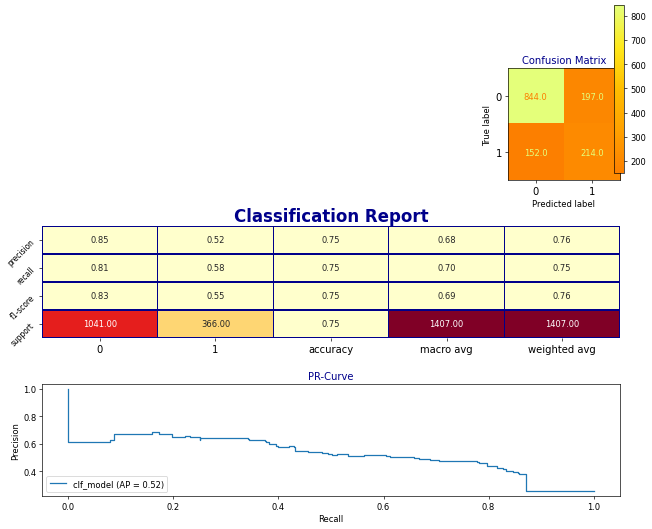

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [34]:
test_eval(clf_df_tom, X_test, y_test, 'Decision Tree', 'smote+tomek')

5. **SMOTE + ENN Resmapling**

In [35]:
clf_df_enn = clf_df.fit(X_train_smenn, y_train_smenn)
clf_params = clf_df_enn.best_params_
pd.DataFrame.from_dict(clf_df_enn.best_params_, orient= 'index', columns = ['DecisionTree (SMOTE+ENN)'])

,DecisionTree (SMOTE+ENN)
max_depth,9
min_samples_leaf,1
min_samples_split,15


AUC-ROC
0.7619210721091006


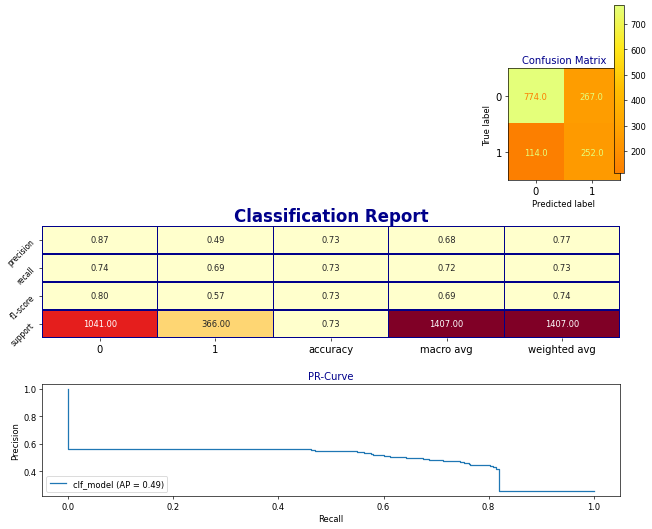

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [36]:
test_eval(clf_df_enn, X_test, y_test, 'Decision Tree', 'smote+enn')

# Model-3 Random Forest

**1. Original Unsampled data**

In [37]:
rf_params={'n_estimators':estimators,
           'max_depth':max_depth,
           'min_samples_split':min_samples_split}
clf_rf = GridSearchCV(RandomForestClassifier(), param_grid= rf_params , cv = cv ,scoring= 'roc_auc').fit(X_train, y_train)

pd.DataFrame.from_dict(clf_rf.best_params_, orient= 'index', columns = ['RandomForest (unsampled)'])

,RandomForest (unsampled)
max_depth,7
min_samples_split,15
n_estimators,50


AUC-ROC
0.8267730691905115


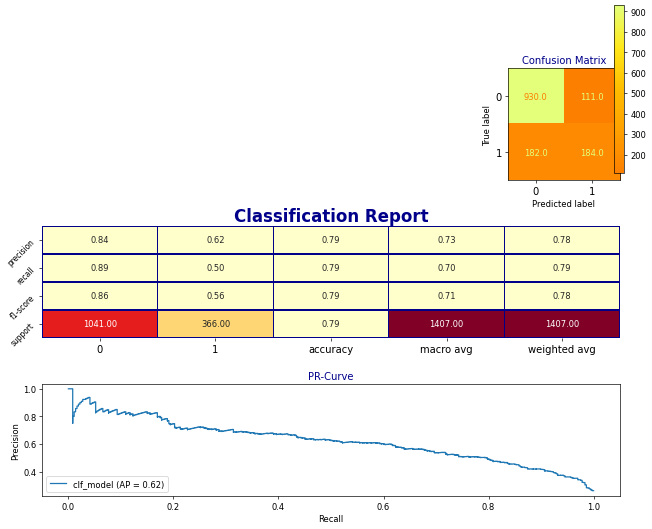

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [38]:
test_eval(clf_rf, X_test, y_test, 'Random Forest', 'actual')

**2. SMOTE Resampling**

In [39]:
clf_rf_smote = clf_rf.fit(X_train_sm, y_train_sm)
clf_params = clf_rf_smote.best_params_
pd.DataFrame.from_dict(clf_rf_smote.best_params_, orient= 'index', columns = ['RandomForest (SMOTE)'])

,RandomForest (SMOTE)
max_depth,15
min_samples_split,10
n_estimators,50


AUC-ROC
0.8183151971360031


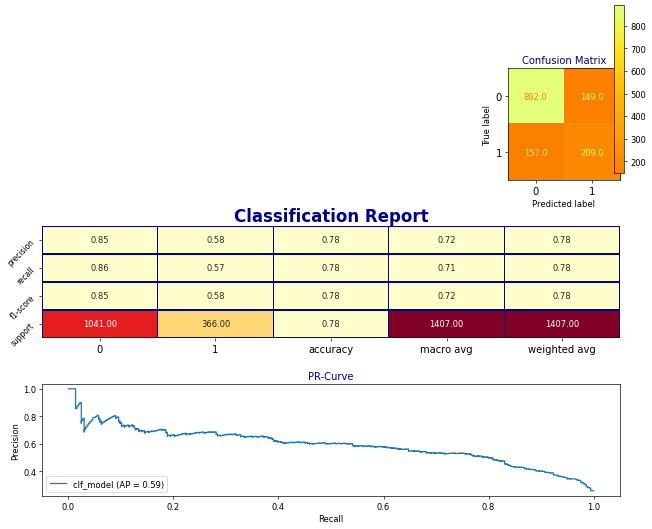

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [40]:
test_eval(clf_rf_smote, X_test, y_test, 'Random Forest', 'smote')

**3. ADASYN Resampling**

In [41]:
clf_rf_ada = clf_rf.fit(X_train_ada, y_train_ada)
clf_params = clf_rf_ada.best_params_
pd.DataFrame.from_dict(clf_rf_ada.best_params_, orient= 'index', columns = ['RandomForest (ADASYNc)'])

,RandomForest (ADASYNc)
max_depth,15
min_samples_split,15
n_estimators,50


AUC-ROC
0.8194529744938399


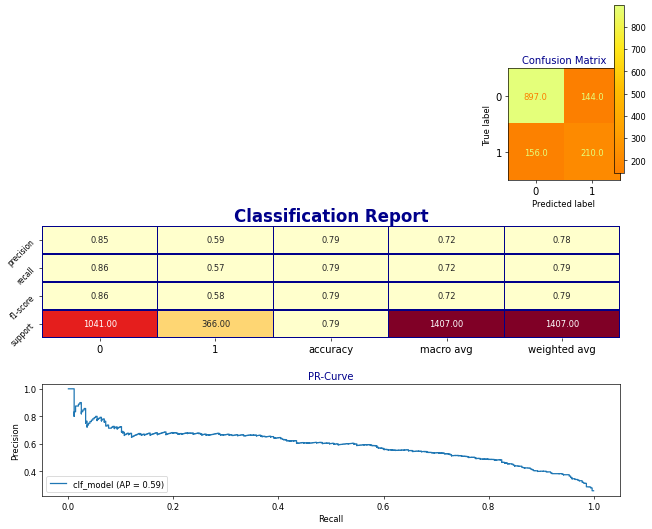

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [42]:
test_eval(clf_rf_ada, X_test, y_test, 'Random Forest', 'adasyn')

**4. SMOTE + Tomek Resampling**

In [43]:
clf_rf_tom = clf_rf.fit(X_train_smtom, y_train_smtom)
clf_params = clf_rf_tom.best_params_
pd.DataFrame.from_dict(clf_rf_tom.best_params_, orient= 'index', columns = ['RandomForest (SMOTE+tomek)'])

,RandomForest (SMOTE+tomek)
max_depth,15
min_samples_split,5
n_estimators,50


AUC-ROC
0.8182692661007964


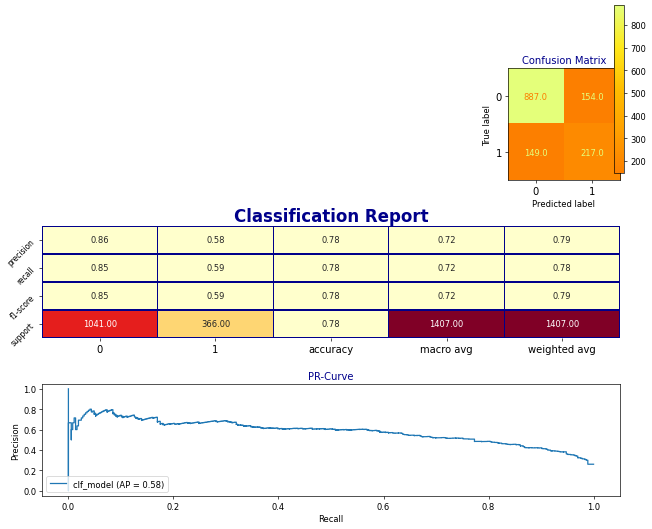

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [44]:
test_eval(clf_rf_tom, X_test, y_test, 'Random Forest', 'smote+tomek')

**5. SMOTE + ENN Resmapling**

In [45]:
clf_rf_enn= clf_rf.fit(X_train_smenn, y_train_smenn)
pd.DataFrame.from_dict(clf_rf_enn.best_params_, orient= 'index', columns = ['RandomForest(SMOTE+ENN)'])

,RandomForest(SMOTE+ENN)
max_depth,15
min_samples_split,2
n_estimators,50


AUC-ROC
0.8128992719274761


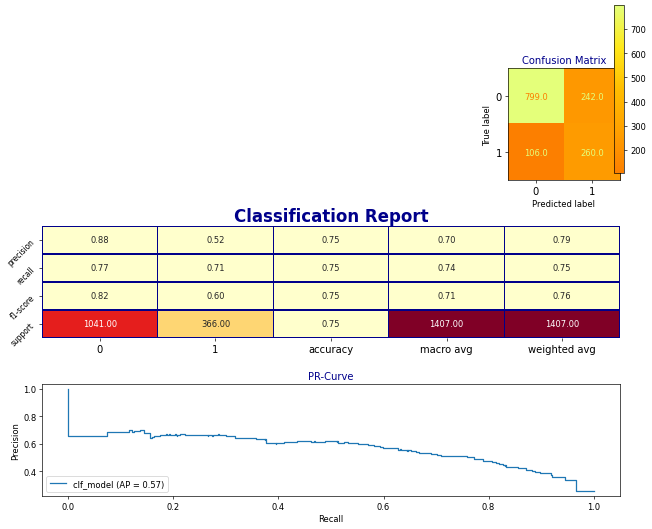

<Figure size 864x432 with 0 Axes>

<Figure size 864x360 with 0 Axes>

In [46]:
test_eval(clf_rf_enn, X_test, y_test, 'Random Forest', 'smote+enn')

# Model Comparison

In [48]:
clf_eval_df = pd.DataFrame({'model':classifier,
                            'resample':resample,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'AUC-ROC':AUCROC})

cn = sns.light_palette( 'pink',as_cmap=True)
clf_eval_df.sort_values(by = 'recall', ascending= True)
# coloring based on their performance
clf_eval_df.style.background_gradient(cmap=cn)

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.492174,0.773224,0.601488,0.825567
1,Logistic Regression,smote,0.500000,0.778689,0.608974,0.825911
2,Logistic Regression,adasyn,0.478191,0.808743,0.601015,0.824971
3,Logistic Regression,smote+tomek,0.494845,0.786885,0.607595,0.826227
4,Logistic Regression,smote+enn,0.476351,0.770492,0.588727,0.817087
5,Decision Tree,actual,0.578406,0.614754,0.596026,0.812864
6,Decision Tree,smote,0.547847,0.625683,0.584184,0.786868
7,Decision Tree,adasyn,0.533679,0.562842,0.547872,0.774164
8,Decision Tree,smote+tomek,0.520681,0.584699,0.550837,0.775378
9,Decision Tree,smote+enn,0.485549,0.688525,0.569492,0.761921


`Thus, average precision is high when your model can correctly handle positivesAverage precision is calculated as the area under a curve that measures the trade off between precision and recall at different decision thresholds:`

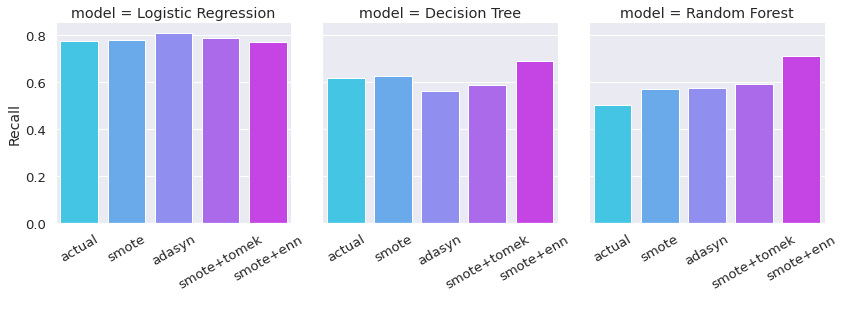

In [49]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=4)
g.map(sns.barplot, "resample", "recall", palette='cool', order=["actual", "smote", "adasyn", "smote+tomek", "smote+enn"])
g.set_xticklabels(rotation=30)
g.set_xlabels('  ', fontsize=14)
g.set_ylabels('Recall', fontsize=14)